# PCA of EEG Features (Dortmund Dataset)
This notebook describes the process of applying PCA to EEG-derived features, exploring dimensionality reduction, and preparing data for clustering.

- Objective: Reduce high-dimensional EEG features to a lower-dimensional space to explore participant variability.
- Dataset: Dortmund dataset (608 participants, multiple EEG features).
- Goals:
  1. Understand structure of the features.
  2. Perform PCA for dimensionality reduction.
  3. Explore variance explained by principal components.
  4. Prepare data for clustering and visualization.

## Load Data
Load the Dortmund dataset and inspect the first few rows.

In [17]:
import pandas as pd
import numpy as np

dort = pd.read_csv("./dataset/Dortmund_features.csv", index_col=0)  # Keep subject IDs as index!
age_sex_dort = pd.read_csv("./dataset/Dortmund_age&sex.csv", index_col=0)
# Extract age and sex
age_dort = age_sex_dort['age'].values
sex_dort = age_sex_dort['sex'].values

lemon = pd.read_csv("./dataset/Lemon_features.csv", index_col=0)  # Keep subject IDs as index!
age_sex_lemon = pd.read_csv("./dataset/Lemon_age&sex.csv", index_col=0)
# Extract age and sex
age_lemon = age_sex_lemon['age_group'].values # note ages are ranges in Lemon
sex_lemon = age_sex_lemon['sex'].values

## Exploratory Data Analysis
- Preview first few rows and numeric columns.
- Check for missing values.
- Examine feature distributions.

In [18]:
# Print dataset shapes
print(f"Dortmund_features.csv shape: {dort.shape}")
print(f"LEMON_features.csv shape: {lemon.shape}\n")

dort_cols = set(dort.columns)
lemon_cols = set(lemon.columns)

print("Features only in Dortmund:")
print(dort_cols - lemon_cols, "\n")

print("Features only in LEMON:")
print(lemon_cols - dort_cols, "\n")


Dortmund_features.csv shape: (600, 147)
LEMON_features.csv shape: (190, 147)

Features only in Dortmund:
set() 

Features only in LEMON:
set() 



All features are shared in Dortmund and Lemon

1. Scatter Plot of First Two Raw Features


Plotting the first two numeric features:
Feature 1: nl_rqa mean diag length
Feature 2: kurtosis_amp_theta



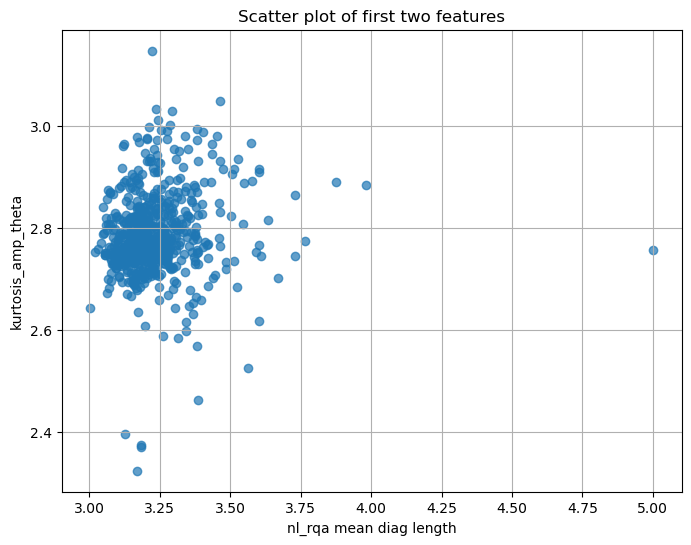

In [19]:
import matplotlib.pyplot as plt

# Select only numeric columns (exclude IDs or non-numeric)
numeric_data = dort.select_dtypes(include=['float64', 'int64'])
dort_numeric = numeric_data.values

# Define features (all numeric columns)
features = dort_numeric  # shape: (participants, features)

# Print what we are plotting
print("Plotting the first two numeric features:")
print(f"Feature 1: {numeric_data.columns[0]}")
print(f"Feature 2: {numeric_data.columns[1]}\n")

# Scatter plot of first two features
plt.figure(figsize=(8,6))
plt.scatter(features[:, 0], features[:, 1], alpha=0.7)
plt.xlabel(numeric_data.columns[0])
plt.ylabel(numeric_data.columns[1])
plt.title("Scatter plot of first two features")
plt.grid(True)
plt.show()


2. Feature-Age/Sex Relationship
-   **Age** — plotted using scatter plots  
-   **Sex** — plotted using boxplots (female vs male)

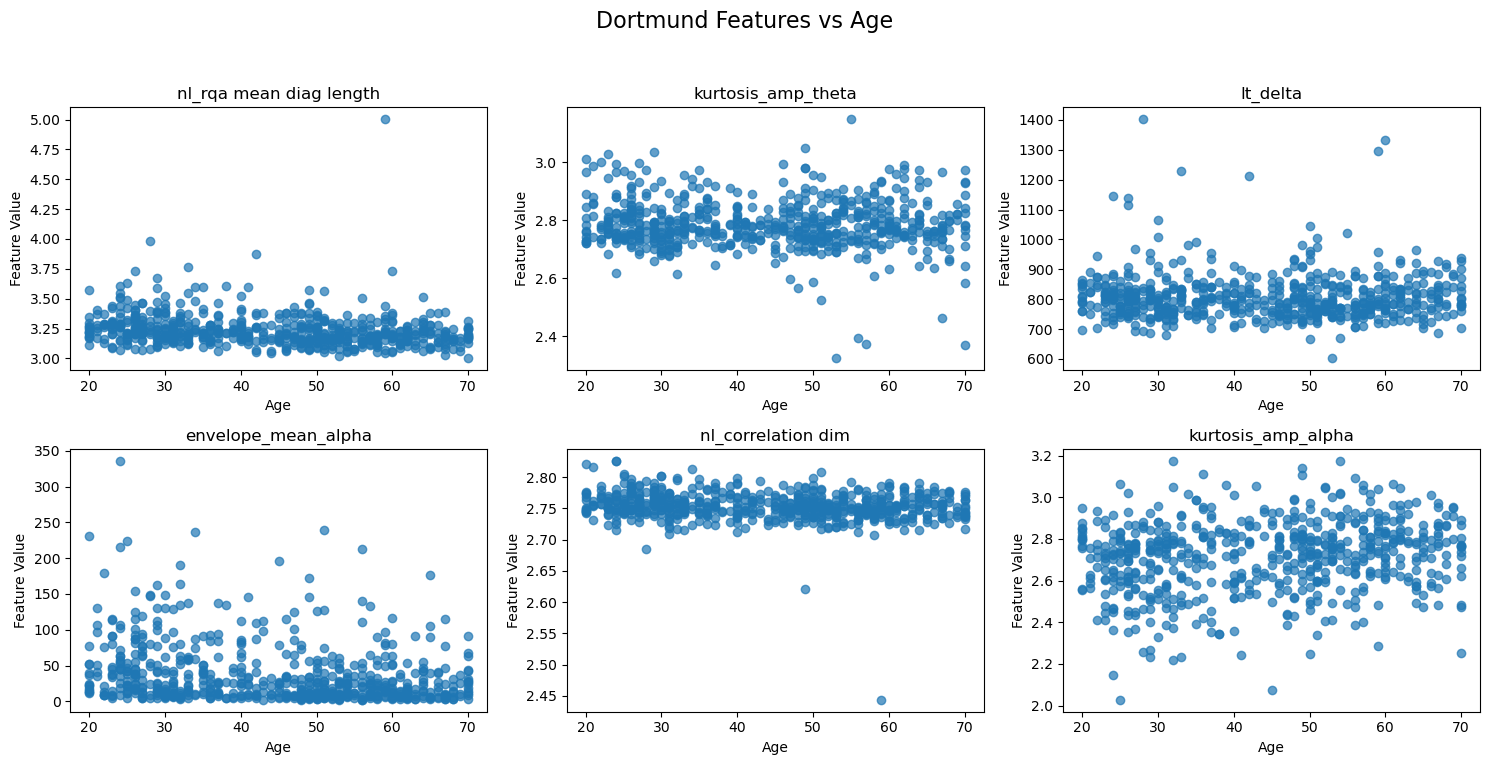

/var/folders/8g/xxs_fk6n0wx22j3lv0pzth1m0000gn/T/ipykernel_3041/479824353.py:28: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[i].boxplot([dort_numeric.iloc[sex_dort=='F', i], dort_numeric.iloc[sex_dort=='M', i]],
/var/folders/8g/xxs_fk6n0wx22j3lv0pzth1m0000gn/T/ipykernel_3041/479824353.py:28: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[i].boxplot([dort_numeric.iloc[sex_dort=='F', i], dort_numeric.iloc[sex_dort=='M', i]],
/var/folders/8g/xxs_fk6n0wx22j3lv0pzth1m0000gn/T/ipykernel_3041/479824353.py:28: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[i].boxplot([dort_numeric.iloc[sex_dort=='F', i], dort_n

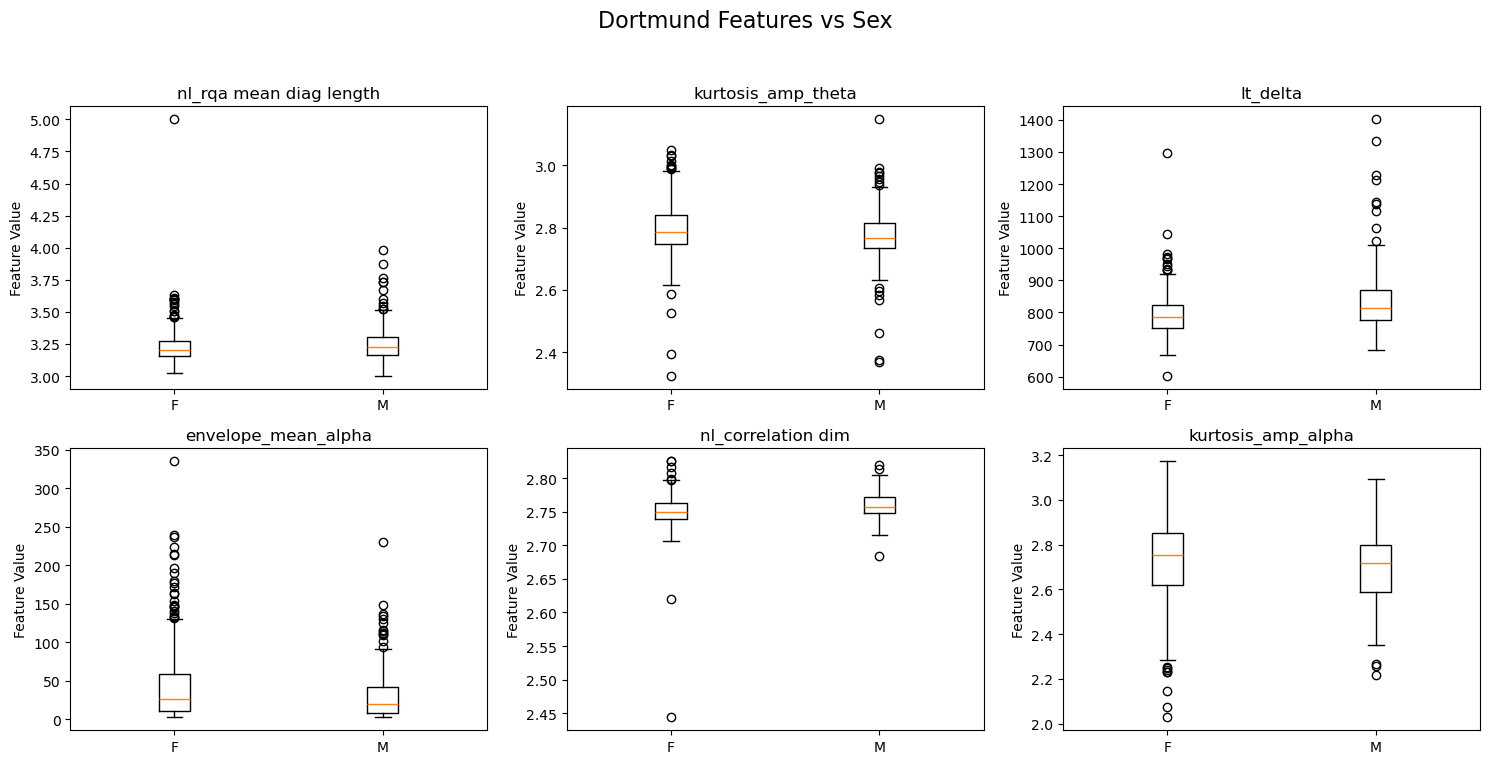

In [20]:
# Numeric Dortmund features
dort_numeric = dort.select_dtypes(include=['float64', 'int64'])
num_features_to_plot = 6

# -------------------------
# Plot features vs Age
# -------------------------
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 8))
axes = axes.flatten()

for i in range(num_features_to_plot):
    axes[i].scatter(age_dort, dort_numeric.iloc[:, i], alpha=0.7)
    axes[i].set_title(dort_numeric.columns[i])
    axes[i].set_xlabel("Age")
    axes[i].set_ylabel("Feature Value")

plt.suptitle("Dortmund Features vs Age", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# -------------------------
# Plot features vs Sex
# -------------------------
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 8))
axes = axes.flatten()

for i in range(num_features_to_plot):
    axes[i].boxplot([dort_numeric.iloc[sex_dort=='F', i], dort_numeric.iloc[sex_dort=='M', i]],
                    labels=['F','M'])
    axes[i].set_title(dort_numeric.columns[i])
    axes[i].set_ylabel("Feature Value")

plt.suptitle("Dortmund Features vs Sex", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


## Principal Component Analysis (PCA)
- Reduce dimensionality to an optimal number of PCs for clustering while optionally visualizing in 2D.
- Examine explained variance, singular values, and component loadings to understand feature contributions.


1. Standardize Features
- PCA is sensitive to scale, so all numeric features are standardized to mean = 0 and variance = 1 before PCA.

2. Optimal PCA Computation
- Compute full PCA and determine the minimum number of PCs needed to reach a threshold variance (default 80%).
- Plot cumulative explained variance and scree plot to visualize the variance captured by each component.

3.  PCA Component Loadings & Transformed Data
- Loadings indicate how strongly each original feature contributes to each principal component.
- Transformed PCA data (scores) are used for clustering.
- Optionally export loadings and PCA-transformed dataset for further analysis.

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt

def run_optimal_pca(data, threshold=0.8, dataset_name="Dataset", export=False):
    """
    Standardizes data, computes full PCA, finds optimal PCs using cumulative variance,
    plots PCA results, and returns PCA-transformed data and components.
    
    Parameters:
        data : pandas DataFrame (numeric)
        threshold : float, e.g. 0.8 for 80% variance
        dataset_name : str (used in plot titles)
        
    Returns:
        pca_optimal_components : np.array (PCA-transformed data)
        pca_model_optimal : PCA object fitted with optimal n_components
        num_pcs_threshold : int (optimal number of PCs)
        explained_variance_full : np.array (all PCs variance)
        components_optimal : np.array (loadings)
    """

    # 1. Standardize
    scaled = StandardScaler().fit_transform(data)

    # 2. Full PCA
    pca_full = PCA()
    pca_full.fit(scaled)

    explained_variance_full = pca_full.explained_variance_ratio_
    cumulative = np.cumsum(explained_variance_full)

    # 3. Determine optimal PCs
    num_pcs_threshold = np.argmax(cumulative >= threshold) + 1

    # --- Plotting ---
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Cumulative plot
    axes[0].plot(range(1, len(cumulative)+1), cumulative*100, marker='o')
    axes[0].axvline(num_pcs_threshold, color='r', linestyle='--',
                    label=f'{int(threshold*100)}% at PC{num_pcs_threshold}')
    axes[0].set_title(f"{dataset_name}: Cumulative Explained Variance")
    axes[0].set_xlabel("Number of Principal Components")
    axes[0].set_ylabel("Cumulative Explained Variance (%)")
    axes[0].legend()
    axes[0].grid(True)

    # Scree plot
    axes[1].plot(range(1, len(explained_variance_full)+1),
                 explained_variance_full*100, marker='o', alpha=0.7)
    axes[1].axhline(explained_variance_full[num_pcs_threshold-1]*100,
                    color='r', linestyle='--',
                    label=f'PC{num_pcs_threshold} variance')
    axes[1].set_title(f"{dataset_name}: Scree Plot")
    axes[1].set_xlabel("Principal Component")
    axes[1].set_ylabel("Explained Variance (%)")
    axes[1].legend()
    axes[1].grid(True)

    plt.tight_layout()
    plt.show()

    # 4. Run optimal PCA
    pca_optimal = PCA(n_components=num_pcs_threshold)
    transformed = pca_optimal.fit_transform(scaled)

    # --- Printing ---
    print(f"\n=== {dataset_name}: Optimal PCA Summary ===")
    print(f"Optimal number of PCs for {int(threshold*100)}% variance: {num_pcs_threshold}")
    print(f"Variance explained by PC1: {explained_variance_full[0]*100:.2f}%")
    print(f"Total variance explained by {num_pcs_threshold} PCs: {cumulative[num_pcs_threshold-1]*100:.2f}%\n")

    print("\n=== Explained Variance of Optimal PCs ===")
    for i, v in enumerate(pca_optimal.explained_variance_ratio_, start=1):
        print(f"PC{i}: {v*100:.2f}%")

    print("\n=== First 5 Singular Values ===")
    print(pca_optimal.singular_values_[:5])

    print("\n=== PCA Loadings (First 3 Features Per PC) ===")
    for i, pc in enumerate(pca_optimal.components_, start=1):
        print(f"PC{i}: {pc[:3]}")


    # --------------------------- #
    # 5. Optional export to CSV
    # --------------------------- #
    # --------------------------- #
    # 5. Optional export to CSV
    # --------------------------- #
    if export:
        # --- PCA Components (Loadings) ---
        # Rows = PCs, Columns = original features
        # This shows HOW MUCH each original feature contributes to each PC
        loadings_df = pd.DataFrame(
            pca_optimal.components_,
            columns=data.columns,
            index=[f"PC{i+1}" for i in range(num_pcs_threshold)]
        )
        loadings_path = f"dataset/{dataset_name}_pca_loadings.csv"
        loadings_df.to_csv(loadings_path, index=True)

        # --- PCA Transformed Data ---
        # Rows = Subjects, Columns = PCs
        # This is what you use for CLUSTERING
        transformed_df = pd.DataFrame(
            transformed,
            index=data.index, # Keep original subject IDs!
            columns=[f"PC{i+1}" for i in range(num_pcs_threshold)]
        )
        transformed_path = f"dataset/{dataset_name}_pca.csv"
        transformed_df.to_csv(transformed_path, index=True)

        print(f"\n✓ Exported loadings to:     {loadings_path}")
        print(f"✓ Exported PCA scores to:   {transformed_path}")
        print(f"  Subject IDs preserved: {transformed_df.index[:3].tolist()}... (first 3)")

    return transformed, pca_optimal, num_pcs_threshold, explained_variance_full, pca_optimal.components_


OPTIMAL PCA (DORTMUND DATASET):

data_pca      → The PCA-transformed dataset (participants × optimal PCs).
                These are the coordinates of each subject in PCA space.

data_model    → The fitted PCA model object.
                Contains components_, explained_variance_ratio_, singular_values_, etc.

data_nPC      → The optimal number of principal components selected automatically.
                Determined by reaching the cumulative variance threshold (e.g., 80%).

data_var      → Explained variance ratio of each selected PC.
                Tells you how much variance each principal component captures.

data_loadings → PCA loadings (components): contribution of each original feature to each PC.
                Shape = (nPC × n_features). Used for interpretation and clustering.

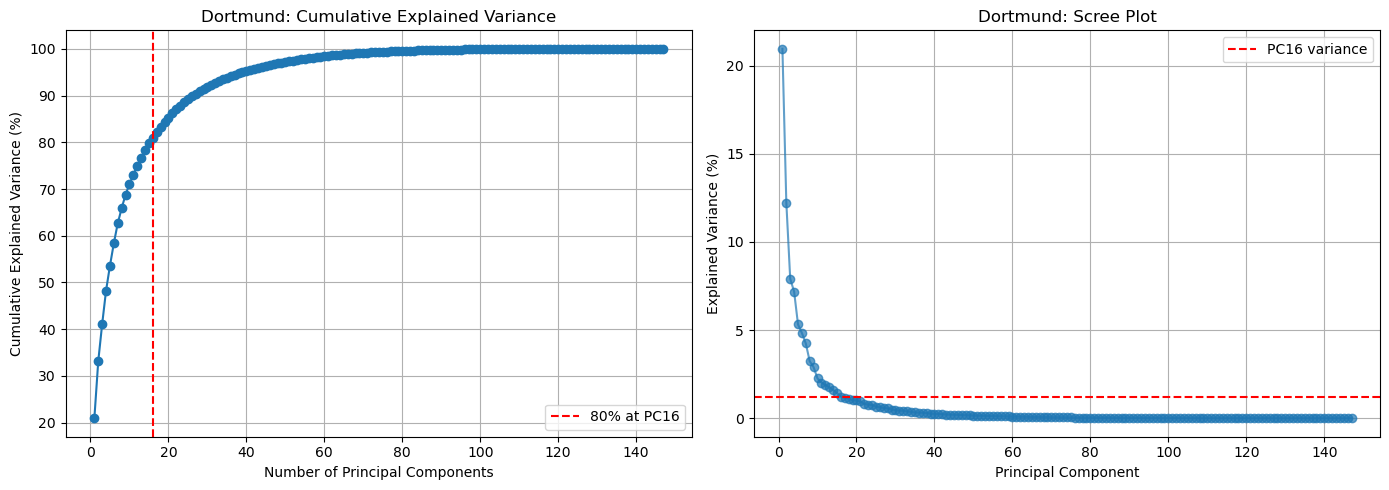


=== Dortmund: Optimal PCA Summary ===
Optimal number of PCs for 80% variance: 16
Variance explained by PC1: 20.95%
Total variance explained by 16 PCs: 80.96%


=== Explained Variance of Optimal PCs ===
PC1: 20.95%
PC2: 12.23%
PC3: 7.91%
PC4: 7.18%
PC5: 5.32%
PC6: 4.83%
PC7: 4.24%
PC8: 3.23%
PC9: 2.90%
PC10: 2.26%
PC11: 2.02%
PC12: 1.89%
PC13: 1.76%
PC14: 1.61%
PC15: 1.43%
PC16: 1.22%

=== First 5 Singular Values ===
[135.92426733 103.85380041  83.50298095  79.57932546  68.48214733]

=== PCA Loadings (First 3 Features Per PC) ===
PC1: [ 0.07755219  0.03162877 -0.02748839]
PC2: [-0.17531184 -0.01302    -0.12494591]
PC3: [-0.05803098 -0.06893938 -0.13057858]
PC4: [-0.01288443  0.02623786 -0.09575212]
PC5: [ 0.06350338 -0.12897026 -0.02706506]
PC6: [0.03377104 0.01408668 0.08135457]
PC7: [0.08087472 0.0848093  0.04429358]
PC8: [-0.07382418  0.09191215 -0.0999502 ]
PC9: [0.0062075  0.06775693 0.07688185]
PC10: [-0.02041419 -0.1167622  -0.0364991 ]
PC11: [0.0052107  0.23632801 0.1038325 ]
P

In [49]:
dort_numeric = dort.select_dtypes(include=['float64', 'int64'])
dort_pca, dort_model, dort_nPC, dort_var, dort_loadings = run_optimal_pca(
    dort_numeric,
    threshold=0.80,
    dataset_name="Dortmund",
    export=True
)

OPTIMAL PCA (LEMON DATASET):

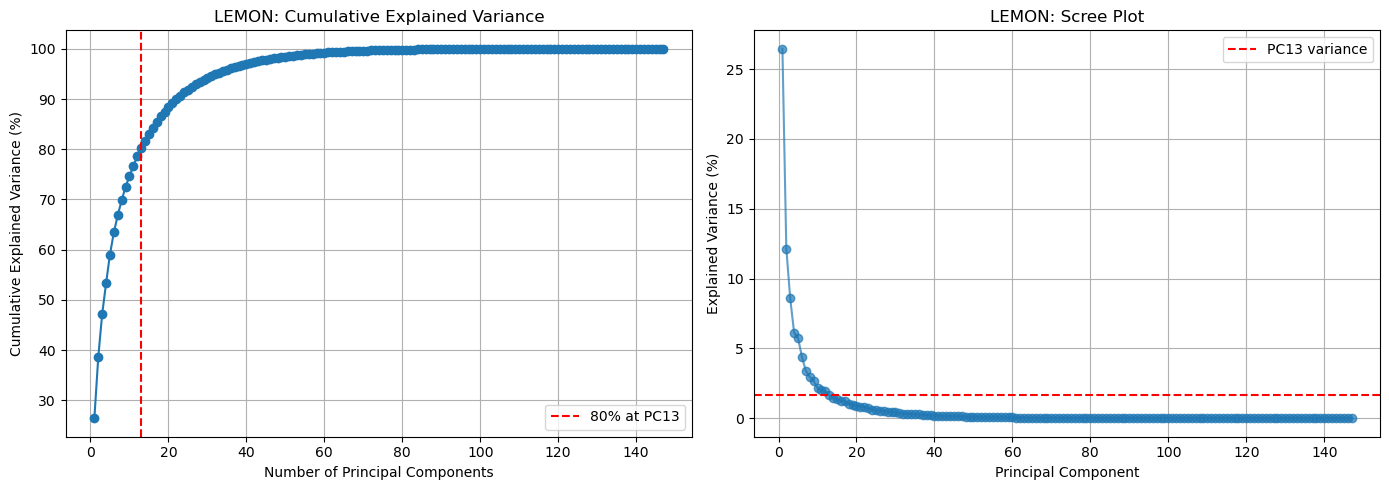


=== LEMON: Optimal PCA Summary ===
Optimal number of PCs for 80% variance: 13
Variance explained by PC1: 26.45%
Total variance explained by 13 PCs: 80.24%

=== Explained Variance of Optimal PCs ===
PC1: 26.45%
PC2: 12.15%
PC3: 8.57%
PC4: 6.13%
PC5: 5.75%
PC6: 4.41%
PC7: 3.40%
PC8: 2.96%
PC9: 2.68%
PC10: 2.15%
PC11: 2.01%
PC12: 1.93%
PC13: 1.64%

=== First 5 Singular Values ===
[85.9498367  58.24597055 48.9346571  41.37887684 40.0681235 ]

=== PCA Loadings (First 3 Features Per PC) ===
PC1: [0.1183683  0.00626448 0.06426968]
PC2: [-0.01681211  0.05213916 -0.10845719]
PC3: [ 0.04190047 -0.01404165  0.09092072]
PC4: [-0.00944458  0.11810503  0.12506928]
PC5: [0.15848921 0.02815616 0.03572152]
PC6: [-0.0697668  -0.02414548 -0.02613632]
PC7: [ 0.03277971  0.0790457  -0.14885173]
PC8: [-0.02086367 -0.14332598  0.05058819]
PC9: [ 0.00972326  0.17819356 -0.03012205]
PC10: [ 0.07506859 -0.07097608  0.02327065]
PC11: [-0.00868137 -0.18580685 -0.04964539]
PC12: [ 0.00321458 -0.22565086  0.104366

In [43]:
lemon_numeric = lemon.select_dtypes(include=['float64', 'int64'])
lemon_pca, lemon_model, lemon_nPC, lemon_var, lemon_loadings = run_optimal_pca(
    lemon_numeric,
    threshold=0.8,
    dataset_name="LEMON",
    export=True
)


## APPENDIX (IGNORE)

In [ ]:
"""--- JUST FOR PURPOSES OF SAVING IF THE PLOTS DONT WORK
# Fit PCA on standardized data (no limit on number of components now)
pca = PCA()
pca.fit_transform(dort_scaled)

# Explained variance ratio for each PC
normalised_values=pca.explained_variance_ratio_ 

# Cumulative explained variance as percentage
cumulative_sum = np.cumsum(normalised_values) * 100

# --- Automatic cutoff: number of PCs needed to reach 80% variance ---
threshold = 0.8  # 80% variance
num_pcs_threshold = np.argmax(np.cumsum(normalised_values) >= threshold) + 1

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Cumulative variance plot
axes[0].plot(range(1, len(normalised_values)+1), cumulative_sum, marker='o', linestyle='-')
axes[0].axvline(x=num_pcs_threshold, color='r', linestyle='--', 
                label=f'80% Variance at PC{num_pcs_threshold}')
axes[0].set_xlabel("Number of Principal Components")
axes[0].set_ylabel("Cumulative Explained Variance (%)")
axes[0].set_title("Cumulative Explained Variance")
axes[0].grid(True)
axes[0].legend()

# Scree plot: variance explained by each PC
axes[1].plot(range(1, len(normalised_values)+1), normalised_values*100, marker='o', linestyle='-', alpha=0.7)
axes[1].axhline(y=normalised_values[num_pcs_threshold-1]*100, color='r', linestyle='--',
                label=f'Variance of PC{num_pcs_threshold}')
axes[1].legend()
axes[1].set_xlabel("Principal Component")
axes[1].set_ylabel("Explained Variance (%)")
axes[1].set_title("Scree Plot")
axes[1].grid(True)

plt.tight_layout()
plt.show()


# Print the variance explained by the first principal component
print(f"Variance explained by the first PC: {normalised_values[0]*100:.2f}%")
print(f"Number of PCs needed to reach 80% variance: {num_pcs_threshold}")

"""

"""--- PCA with optimal number of components (n=16) ---
pca_optimal = PCA(n_components=16)
dort_pca_optimal = pca_optimal.fit_transform(dort_scaled)

print("=== Feature Space Size ===")
print(f"Original features: {dort.shape}")
print(f"PCA-reduced features: {dort_pca_optimal.shape}\n")

explained_variance_optimal = pca_optimal.explained_variance_ratio_
singular_values_optimal=pca_optimal.singular_values_
components_optimal = pca_optimal.components_

# Explained variance
print("=== Explained Variance Ratio (Each PC) ===")
for i, var in enumerate(explained_variance_optimal, start=1):
    print(f"PC{i}: {var*100:.2f}%")
print(f"Cumulative variance explained by first 2 PCs: {explained_variance_optimal[:2].sum()*100:.2f}%\n")

# Singular values
print("=== Singular Values (first 5) ===")
print(singular_values_optimal[:5], "\n")

# PCA Components (show first 3 features per PC for brevity)
print("=== PCA Components Loadings (first 3 features per PC) ===")
for i, pc in enumerate(components_optimal, start=1):
    print(f"PC{i}: {pc[:3]}")
"""

=== Feature Space Size ===
Original features: (600, 147)
PCA-reduced features: (600, 16)

=== Explained Variance Ratio (Each PC) ===
PC1: 20.95%
PC2: 12.23%
PC3: 7.91%
PC4: 7.18%
PC5: 5.32%
PC6: 4.83%
PC7: 4.24%
PC8: 3.23%
PC9: 2.90%
PC10: 2.26%
PC11: 2.02%
PC12: 1.89%
PC13: 1.76%
PC14: 1.61%
PC15: 1.43%
PC16: 1.21%
Cumulative variance explained by first 2 PCs: 33.18%

=== Singular Values (first 5) ===
[135.92426733 103.85380041  83.50298096  79.57932545  68.48214755] 

=== PCA Components Loadings (first 3 features per PC) ===
PC1: [ 0.07755219  0.03162877 -0.02748839]
PC2: [-0.1753119  -0.01301991 -0.12494585]
PC3: [-0.05803049 -0.06893831 -0.13057863]
PC4: [-0.01288408  0.02623678 -0.09575251]
PC5: [ 0.06350009 -0.12897492 -0.02706606]
PC6: [0.03376578 0.0140925  0.08135595]
PC7: [0.08086893 0.08481602 0.044293  ]
PC8: [-0.07382411  0.09174889 -0.10002232]
PC9: [0.00621684 0.06758553 0.07685744]
PC10: [-0.02067983 -0.11636249 -0.03637863]
PC11: [0.00490846 0.23627134 0.10403206]
PC12

### EXPORT DATA AS CSV FILES (ORIGINAL EXPORTING JUST TO SAVE IF FUNCTION PRODUCES DIFFERENT RESULTS)

In [ ]:
"""
# --- PCA Components (Loadings) ---
# Rows = PCs, Columns = original features
# This shows HOW MUCH each original feature contributes to each PC
components_df = pd.DataFrame(
    components_optimal,
    columns=dort_numeric.columns
)
components_df.index = [f'PC{i+1}' for i in range(components_df.shape[0])]
components_df.to_csv("dataset/Dortmund_pca_loadings.csv", index=True)
print("✓ PCA loadings exported to dataset/Dortmund_pca_loadings.csv")

# --- PCA Transformed Data ---
# Rows = Subjects, Columns = PCs
# This is what you use for CLUSTERING
transformed_df = pd.DataFrame(
    dort_pca_optimal,
    index=dort.index,  # Keep original subject IDs!
    columns=[f'PC{i+1}' for i in range(dort_pca_optimal.shape[1])]
)
transformed_df.to_csv("dataset/Dortmund_pca.csv", index=True)
print("✓ PCA transformed data exported to dataset/Dortmund_pca.csv")
print(f"  Subject IDs preserved: {transformed_df.index[:3].tolist()}... (first 3)")
"""

✓ PCA loadings exported to dataset/Dortmund_pca_loadings.csv
✓ PCA transformed data exported to dataset/Dortmund_pca.csv
  Subject IDs preserved: ['sub-001', 'sub-002', 'sub-003']... (first 3)
